# Assignment 2

> Tristan PERROT

## Utils

### Imports


In [34]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import os
import tqdm

np.random.seed(42)
# Fix torch seed
torch.manual_seed(0)

DATASET_PATH = '../Dataset/'

In [35]:
def load_batch(filename):
    """ Copied from the dataset website """
    import pickle
    with open(DATASET_PATH + filename, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data


def load_data(filename):
    """ Read the data from the file """
    data = load_batch(filename)
    X = data[b'data'].T / 255
    y = np.array(data[b'labels'])
    Y = np.zeros((10, X.shape[1]))
    for i in range(y.shape[0]):
        Y[y[i], i] = 1
    return X, Y, y

In [36]:
def compute_relative_error(grad_analytical, grad_numerical, eps=1e-9):
    """ Compute the relative error between the analytical and numerical gradients """
    return torch.max(
        torch.abs(grad_analytical - grad_numerical) / torch.clamp(torch.abs(grad_analytical) + torch.abs(grad_numerical) + eps, min=eps))

## Exercises

### Model


In [65]:
class Classifier():
    def __init__(self, x_train, x_val, x_test, y_train, y_val, y_test, y_1d_train, y_1d_val, y_1d_test, eta=0.001, lambd=0.0):
        self.x_train = torch.tensor(x_train, dtype=torch.float64)
        self.x_val = torch.tensor(x_val, dtype=torch.float64)
        self.x_test = torch.tensor(x_test, dtype=torch.float64)
        self.y_train = torch.tensor(y_train, dtype=torch.float64)
        self.y_val = torch.tensor(y_val, dtype=torch.float64)
        self.y_test = torch.tensor(y_test, dtype=torch.float64)
        self.y_1d_train = torch.tensor(y_1d_train, dtype=torch.float64)
        self.y_1d_val = torch.tensor(y_1d_val, dtype=torch.float64)
        self.y_1d_test = torch.tensor(y_1d_test, dtype=torch.float64)

        self.eta = eta
        self.lambd = lambd

        self.W = []
        self.b = []

        self.costs_train = []
        self.costs_val = []

    def preprocess(self):
        mean_X = torch.mean(self.x_train, axis=1, keepdim=True)
        std_X = torch.std(self.x_train, axis=1, keepdim=True)
        self.x_train = (self.x_train - mean_X) / std_X
        self.x_val = (self.x_val - mean_X) / std_X
        self.x_test = (self.x_test - mean_X) / std_X

    def initialize_weights(self, hidden_size):
        features = self.x_train.shape[0]
        outputs = self.y_train.shape[0]

        W1 = torch.randn(hidden_size, features,
                         dtype=self.x_train.dtype) / math.sqrt(features)
        b1 = torch.zeros(hidden_size, 1, dtype=self.x_train.dtype)
        W2 = torch.randn(outputs, hidden_size,
                         dtype=self.x_train.dtype) / math.sqrt(hidden_size)
        b2 = torch.zeros(outputs, 1, dtype=self.x_train.dtype)
        W1.requires_grad = True
        b1.requires_grad = True
        W2.requires_grad = True
        b2.requires_grad = True
        self.W = [W1, W2]
        self.b = [b1, b2]

    def forward(self, x, W1, b1, W2, b2):
        self.z1 = W1 @ x + b1
        self.h = torch.relu(self.z1)
        self.z2 = W2 @ self.h + b2
        self.p = torch.softmax(self.z2, dim=0)

    def cost(self, x, y, W1, b1, W2, b2):
        m = x.shape[1]
        self.forward(x, W1, b1, W2, b2)
        loss = -torch.sum(y * torch.log(self.p)) / m
        reg = self.lambd * (torch.sum(W1 ** 2) + torch.sum(W2 ** 2))
        return loss + reg

    def cost_grad(self, x, y):
        m = x.shape[1]
        self.forward(x, self.W[0], self.b[0], self.W[1], self.b[1])
        dZ2 = self.p - y
        dW2 = dZ2 @ self.h.T / m + 2 * self.lambd * self.W[1]
        db2 = torch.sum(dZ2, axis=1, keepdim=True) / m
        dH = self.W[1].T @ dZ2
        dZ1 = dH * (self.z1 > 0)
        dW1 = dZ1 @ x.T / m + 2 * self.lambd * self.W[0]
        db1 = torch.sum(dZ1, axis=1, keepdim=True) / m
        return dW1, db1, dW2, db2

    def compute_grads_num(self, X, Y, W, b, h):
        grad_W = [torch.zeros_like(w) for w in W]
        grad_b = [torch.zeros_like(bi) for bi in b]

        c = self.cost(X, Y, W[0], b[0], W[1], b[1])

        for j in range(len(b)):
            for i in range(len(b[j])):
                b_try = [bi.clone() for bi in b]
                b_try[j][i] += h
                c2 = self.cost(X, Y, W[0], b_try[0], W[1], b_try[1])
                grad_b[j][i] = (c2 - c) / h
        for j in range(len(W)):
            for i in range(np.prod(W[j].shape)):
                W_try = [wi.clone() for wi in W]
                idx = np.unravel_index(i, W[j].shape)
                W_try[j][idx] += h
                c2 = self.cost(X, Y, W_try[0], b[0], W_try[1], b[1])
                grad_W[j][idx] = (c2 - c) / h

        return grad_b, grad_W

    def check_grad(self):
        dW1, db1, dW2, db2 = self.cost_grad(self.x_train, self.y_train)

        grad_b, grad_W = self.compute_grads_num(
            self.x_train, self.y_train, self.W, self.b, 1e-5)
        db1_num, dW1_num = grad_b[0], grad_W[0]
        db2_num, dW2_num = grad_b[1], grad_W[1]

        print('Between analytical and numerical gradients:')
        print('Difference for W1:', torch.max(torch.abs(dW1 - dW1_num)))
        print('Difference for b1:', torch.max(torch.abs(db1 - db1_num)))
        print('Difference for W2:', torch.max(torch.abs(dW2 - dW2_num)))
        print('Difference for b2:', torch.max(torch.abs(db2 - db2_num)))
        print('Relative error for W1:', compute_relative_error(dW1, dW1_num))
        print('Relative error for b1:', compute_relative_error(db1, db1_num))
        print('Relative error for W2:', compute_relative_error(dW2, dW2_num))
        print('Relative error for b2:', compute_relative_error(db2, db2_num))

        cost = self.cost(self.x_train, self.y_train, self.W[0], self.b[0], self.W[1], self.b[1])
        cost.backward()
        grad_W1 = self.W[0].grad
        grad_b1 = self.b[0].grad
        grad_W2 = self.W[1].grad
        grad_b2 = self.b[1].grad

        print('\nBetween analytical and torch gradients:')
        print('Difference for W1:', torch.max(torch.abs(dW1 - grad_W1)))
        print('Difference for b1:', torch.max(torch.abs(db1 - grad_b1)))
        print('Difference for W2:', torch.max(torch.abs(dW2 - grad_W2)))
        print('Difference for b2:', torch.max(torch.abs(db2 - grad_b2)))
        print('Relative error for W1:', compute_relative_error(dW1, grad_W1))
        print('Relative error for b1:', compute_relative_error(db1, grad_b1))
        print('Relative error for W2:', compute_relative_error(dW2, grad_W2))
        print('Relative error for b2:', compute_relative_error(db2, grad_b2))

        print('\nBetween torch and numerical gradients:')
        print('Difference for W1:', torch.max(torch.abs(grad_W1 - dW1_num)))
        print('Difference for b1:', torch.max(torch.abs(grad_b1 - db1_num)))
        print('Difference for W2:', torch.max(torch.abs(grad_W2 - dW2_num)))
        print('Difference for b2:', torch.max(torch.abs(grad_b2 - db2_num)))
        print('Relative error for W1:', compute_relative_error(grad_W1, dW1_num))
        print('Relative error for b1:', compute_relative_error(grad_b1, db1_num))
        print('Relative error for W2:', compute_relative_error(grad_W2, dW2_num))
        print('Relative error for b2:', compute_relative_error(grad_b2, db2_num))

        # Reset gradients
        self.W[0].grad.zero_()
        self.b[0].grad.zero_()
        self.W[1].grad.zero_()
        self.b[1].grad.zero_()
    
    def mini_batch_gd(self, n_batch, n_epochs):
        m = self.x_train.shape[1]
        batch_size = m // n_batch
        p_bar = tqdm.trange(n_epochs)
        for epoch in p_bar:
            for i in range(n_batch):
                start = i * batch_size
                end = min((i + 1) * batch_size, m)
                x_batch = self.x_train[:, start:end]
                y_batch = self.y_train[:, start:end]
                dW1, db1, dW2, db2 = self.cost_grad(x_batch, y_batch)
                with torch.no_grad():
                    self.W[0] -= self.eta * dW1
                    self.b[0] -= self.eta * db1
                    self.W[1] -= self.eta * dW2
                    self.b[1] -= self.eta * db2
            cost_train = self.cost(self.x_train, self.y_train, self.W[0], self.b[0], self.W[1], self.b[1])
            cost_val = self.cost(self.x_val, self.y_val, self.W[0], self.b[0], self.W[1], self.b[1])
            self.costs_train.append(cost_train.item())
            self.costs_val.append(cost_val.item())
            p_bar.set_description(f'Cost Train: {cost_train.item():.4f}, Cost Val: {cost_val.item():.4f}')

## Exercice 1 & 2

In [66]:
X_train, Y_train, y_train = load_data('data_batch_1')
X_val, Y_val, y_val = load_data('data_batch_2')
X_test, Y_test, y_test = load_data('test_batch')

n = 20
dim = 50
m = 5

X_train_ = X_train[:dim, :n]
Y_train_ = Y_train[:, :n]
y_train_ = y_train[:n]
X_val_ = X_val[:dim, :n]
Y_val_ = Y_val[:, :n]
y_val_ = y_val[:n]
X_test_ = X_test[:dim, :n]
Y_test_ = Y_test[:, :n]
y_test_ = y_test[:n]

classifier = Classifier(X_train_, X_val_, X_test_, Y_train_,
                  Y_val_, Y_test_, y_train_, y_val_, y_test_, eta=0.001, lambd=0.0)
classifier.preprocess()
classifier.initialize_weights(m)
classifier.check_grad()

Between analytical and numerical gradients:
Difference for W1: tensor(6.6051e-07, dtype=torch.float64, grad_fn=<MaxBackward1>)
Difference for b1: tensor(6.5027e-07, dtype=torch.float64, grad_fn=<MaxBackward1>)
Difference for W2: tensor(8.1319e-07, dtype=torch.float64, grad_fn=<MaxBackward1>)
Difference for b2: tensor(6.3758e-07, dtype=torch.float64, grad_fn=<MaxBackward1>)
Relative error for W1: tensor(0.0002, dtype=torch.float64, grad_fn=<MaxBackward1>)
Relative error for b1: tensor(1.2526e-05, dtype=torch.float64, grad_fn=<MaxBackward1>)
Relative error for W2: tensor(1.2145e-05, dtype=torch.float64, grad_fn=<MaxBackward1>)
Relative error for b2: tensor(1.9469e-05, dtype=torch.float64, grad_fn=<MaxBackward1>)

Between analytical and torch gradients:
Difference for W1: tensor(4.1633e-17, dtype=torch.float64, grad_fn=<MaxBackward1>)
Difference for b1: tensor(4.1633e-17, dtype=torch.float64, grad_fn=<MaxBackward1>)
Difference for W2: tensor(1.3878e-17, dtype=torch.float64, grad_fn=<MaxBa

In [67]:
n = 100
hidden_size = 5

X_train_ = X_train[:, :n]
Y_train_ = Y_train[:, :n]
y_train_ = y_train[:n]
X_val_ = X_val[:, :n]
Y_val_ = Y_val[:, :n]
y_val_ = y_val[:n]
X_test_ = X_test[:, :n]
Y_test_ = Y_test[:, :n]
y_test_ = y_test[:n]

classifier = Classifier(X_train_, X_val_, X_test_, Y_train_,
                    Y_val_, Y_test_, y_train_, y_val_, y_test_, eta=0.005, lambd=0.0)
classifier.preprocess()
classifier.initialize_weights(hidden_size)
classifier.mini_batch_gd(20, 200)


Cost Train: 0.3186, Cost Val: 9.0704: 100%|██████████| 200/200 [00:00<00:00, 258.32it/s]


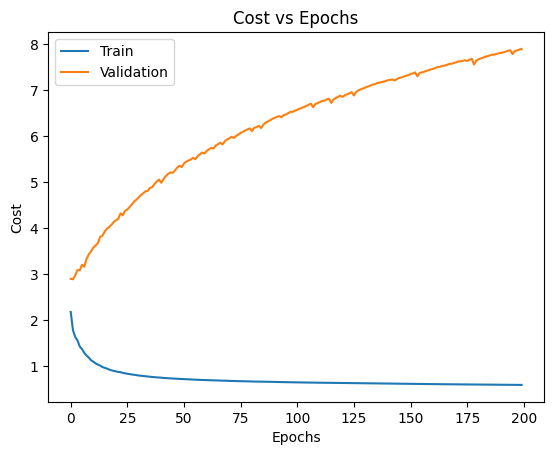

In [58]:
plt.plot(classifier.costs_train, label='Train')
plt.plot(classifier.costs_val, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Cost vs Epochs')
plt.legend()
plt.show()

## Exercice 3